<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Why-we-need-RNNs?" data-toc-modified-id="Why-we-need-RNNs?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Why we need RNNs?</a></span><ul class="toc-item"><li><span><a href="#Basic-NN-with-single-hidden-layer" data-toc-modified-id="Basic-NN-with-single-hidden-layer-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Basic NN with single hidden layer</a></span></li><li><span><a href="#Image-CNN-with-single-dense-hidden-layer" data-toc-modified-id="Image-CNN-with-single-dense-hidden-layer-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Image CNN with single dense hidden layer</a></span></li><li><span><a href="#Predicting-char-3-using-chars-1-&amp;-2" data-toc-modified-id="Predicting-char-3-using-chars-1-&amp;-2-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Predicting char 3 using chars 1 &amp; 2</a></span></li></ul></li><li><span><a href="#RNN" data-toc-modified-id="RNN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>RNN</a></span></li><li><span><a href="#Inception-Network" data-toc-modified-id="Inception-Network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inception Network</a></span><ul class="toc-item"><li><span><a href="#1x1-convolution" data-toc-modified-id="1x1-convolution-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>1x1 convolution</a></span><ul class="toc-item"><li><span><a href="#Factored-Convolutions" data-toc-modified-id="Factored-Convolutions-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Factored Convolutions</a></span></li></ul></li></ul></li><li><span><a href="#image-enhancement." data-toc-modified-id="image-enhancement.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>image enhancement.</a></span></li></ul></div>

[Video](https://www.youtube.com/watch?v=sHcLkfRrgoQ&feature=youtu.be&t=1h9m16s)

# Why we need RNNs?
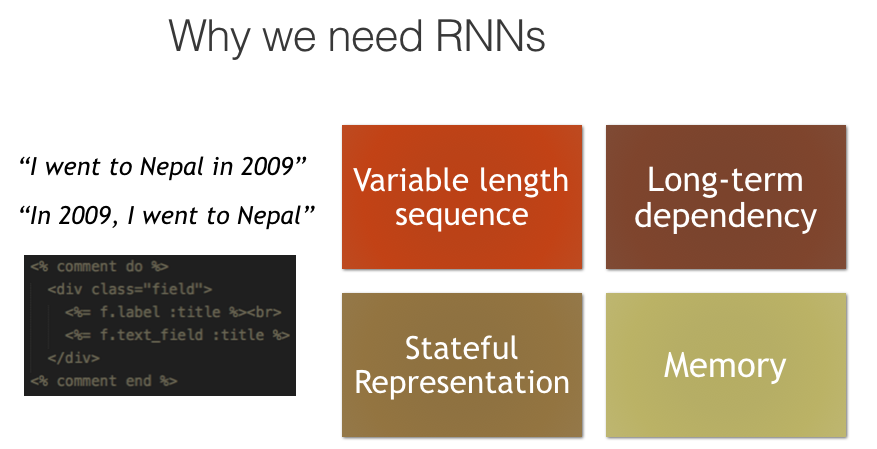

## Basic NN with single hidden layer
All shapes are (matrices of) activations.
An activation is a number that has been calculated eg, by a relu, matrix product, etc. 
A rectangle is an input activations, a circle is a hidden activations and a triangle is an output activations.<br>
An arrow is a layer operation (possibly more than one). 
Check out Machine Learning course lessons (9, 10, 11?) for creating this from scratch.

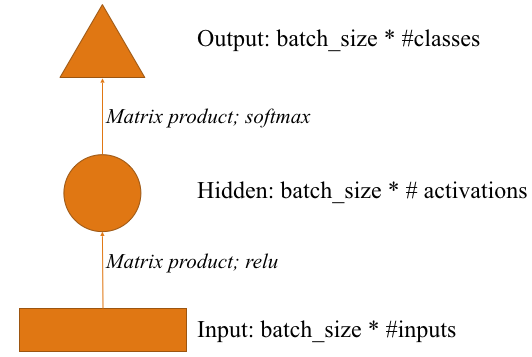

TODO: Write one from scratch.

NB: Batchsize appears everywhere, so we omit it from follow-up figures.
Also, the activation function is almost always relu for the hidden layers, 
softmax for the output layers, so we also omit them. 

## Image CNN with single dense hidden layer
We cover how to flatten a layer later. 
The main method is **“adaptive max pooling”** — where we average across the height and the width and turn it into a vector.

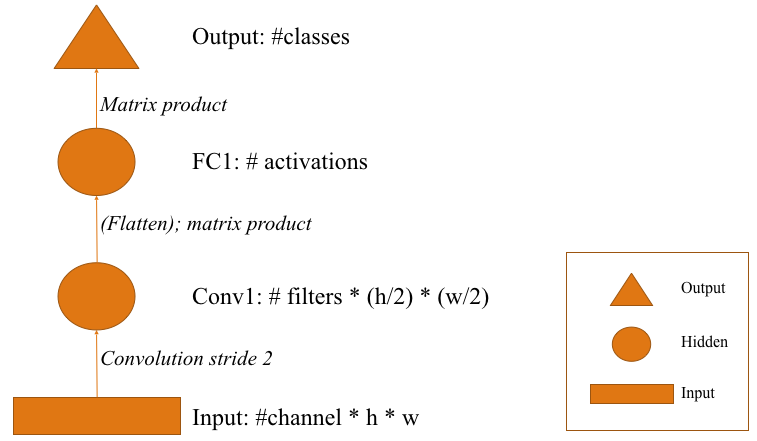

## Predicting char 3 using chars 1 & 2 
[1:18:04]
We are going to implement this one for NLP.

- Input can be one-hot-encoded character (length of vector = # of unique characters) 
or a single integer and pretend it is one-hot-encoded by using an embedding layer.
- The difference from the CNN one is that then char 2 inputs gets added.
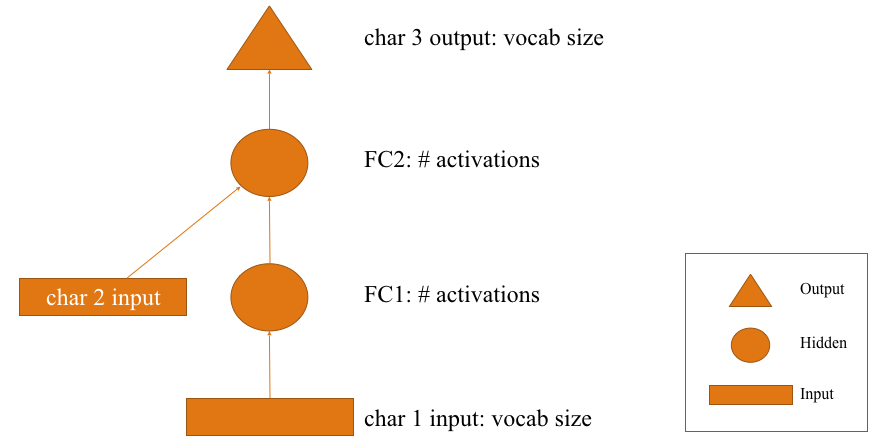

Layer operations no longer shown. Recall arrows represent layer operations.

Here is the updated version of the previous diagram. 
Notice that now arrows are colored. 
NB: **All arrows with the same color will use the same weight matrix.** 
The idea is that a character would have the same meaning (semantically or conceptually) 
regardless of its position (whether it is the 1st, 2nd, or 3rd item in a sequence), so treat them the same.
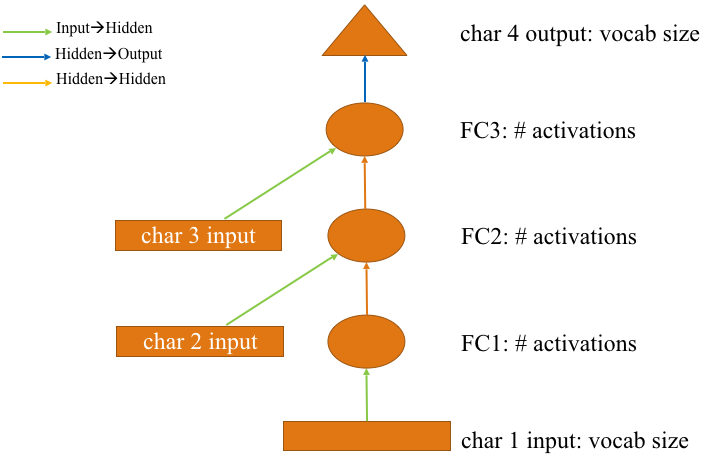

One slight difference from previous is that there are inputs coming in at the second and third layers. We tried two approaches — concatenating and adding these inputs to the current activations.

- By using nn.Linear we get both the weight matrix and the bias vector wrapped up by Pytorch.
- To deal with the fact that there is no orange arrow coming in for the first ellipse, we invented an empty matrix

# RNN
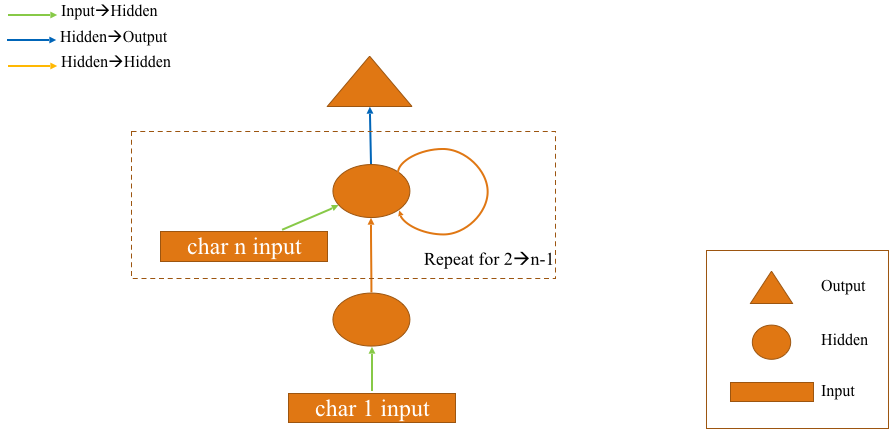

PyTorch version — nn.RNN will create the loop and keep track of h as it goes along.
We are using white section to predict the green character — which seems wasteful as the next section mostly overlaps with the current section.
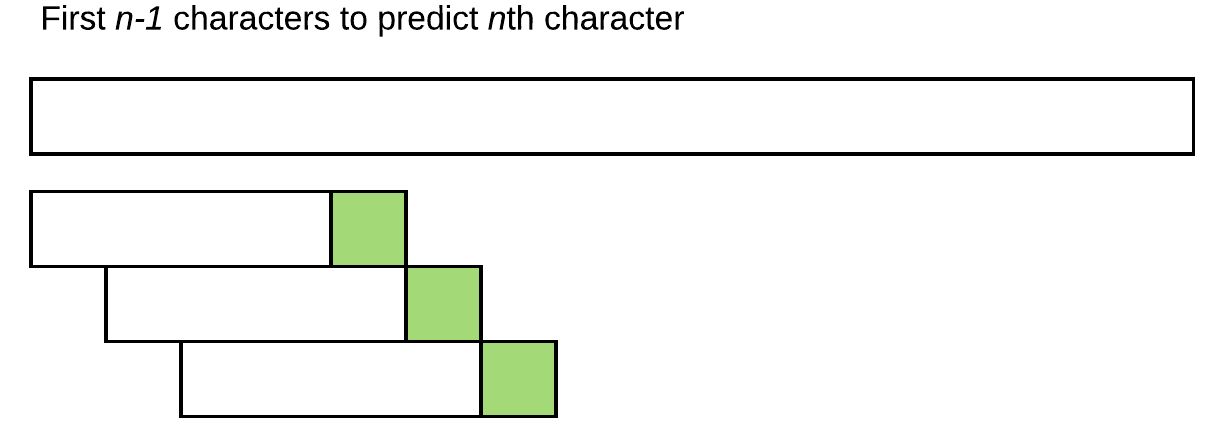

We then tried splitting it into non-overlapping pieces in multi-output model:
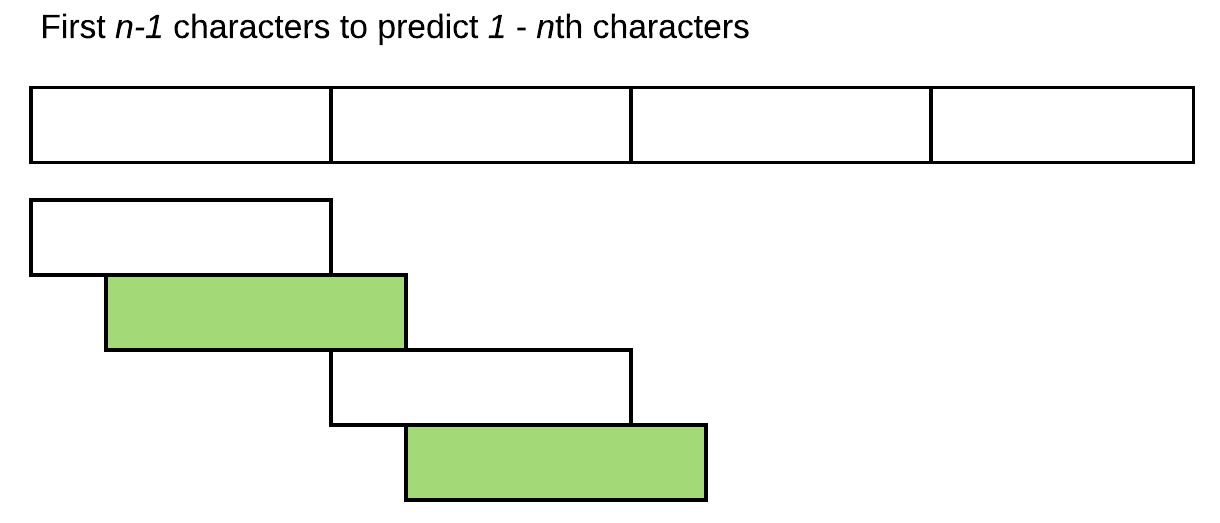

In this approach, we are throwing away our h activation after processing each section and started a new one. In order to predict the second character using the first one in the next section, it has nothing to go on but a default activation. Let’s not throw away h .


# Inception Network
The Inception network is interesting because they use some tricks for efficiency. 
Fastai is not (currently) using these tricks and JH wants to try it. 
The most interesting and successful Inception network is `Inception-ResNet-v2`.
Most of the blocks in that looks something like this:
![image.png](attachment:image.png)

It looks a lot like a standard ResNet block in that there’s an identity connection, and there’s a conv path, and we add them up together [17:47]. 
But it’s not quite that. 
The first difference is the middle conv path is a 1x1 conv.
Lets explore what a 1x1 conv actually is.

## 1x1 convolution 
[18:23]
1x1 conv is saying for each grid cell in your input, you’ve got basically a vector. 
1x1 by number of filters tensor is basically a vector. 
For each grid cell in your input, you’re just doing a dot product with that tensor. 
It’s going to be one of those vectors for each of the 192 activations we are creating. 
So basically do 192 dot products with grid cell (1, 1), 
and then 192 with grid cell (1, 2) or (1, 3) and so forth. <br>
We end up with something which has the same grid size as the input and 192 channels in the output. <br>
It is a good way to either reduce (or increase) the dimensionality of an input without changing the grid size.
That’s normally what we use 1x1 convs for.<br> 

Here, we have a 1x1 conv and another 1x1 conv, and then they add it together. 
Then there is a 3rd path, that is not added but concatenated. 
`DenseNet` is a form of ResNet, but with concat instead of plus.
Interesting approach because the identity path is being copied. 
So we get a flow, all the way through, and that is good for segmentation and other situations 
when we want to keep the original pixels, (and the first and 2nd layer) of pixels untouched.

Concatenating rather than adding branches is a very useful thing to do and we are concatenating the middle branch and the right right branch [20:22]. 
The right most branch is doing something interesting:
1st a 1x1 conv, then a 1x7, and then 7x1. 
What’s going on there? 
What we really want to do is a 7x7 conv. 
We want to do 7x7 conv because if we have multiple paths (each has different kernel sizes), 
then it’s able to look at different amounts of the image. 
The original Inception network had 1x1, 3x3, 5x5, 7x7 getting concatenated together (or something like that). If we have a 7x7 filter, then we look at a lot of the image at once and create a really rich representation. <br>
The stem of the Inception network (the first few layers) actually also used this kind of 7x7 conv.
Because it starts with 224x224x3, and wants to turn it into 112x112x64.<br> 
By using a 7x7 conv, you can get a lot of information in each one of those outputs to get those 64 filters. But, a 7x7 conv is a lot of work. 
It is 49 kernel values to multiply by 49 inputs for every input pixel (224x224) across every channel (x3). 
So the compute is like (361M = $49*49*224*224*3$) ops. 
Can get away with it (maybe) for the very 1st layer, and in fact, the very first conv of ResNet is a 7x7 conv.

But not so for Inception [22:30]. 
They don’t do a 7x7 conv, instead, they do a 1x7 followed by 7x1. 
The idea of the Inception networks is that we have a number of separate paths which have different convolution widths. 
In this case, the middle path is 1x1 convolution width, and the right path is going to be a 7 convolution width, so they are looking at different amount of data and then we combine them together. 
It avoids a 7x7 conv through out the network, because it’s just too computationally expensive.

 [23:18], 
if we’ve got some input coming in and we have some big filter that we want and it’s too big to deal with. What could we do? 
Let’s do 5x5. 
What we can do is to create two filters — one which is 1x5, one which is 5x1. 
We take our activations of the previous layer, and we put it through the 1x5. 
We take the activations out of that, and put it through the 5x1, and something comes out the other end. 
Now what comes out the other end? 
We think of these two operations together and ask:
What is a 5x1 dot product and a 1x5 dot product do together? 
The outer product is a 5x5. 
We can’t create any possible 5x5 matrix by taking that product, but there are many possible 5x5 matrices. 
Often the computation we want can be simpler than a full 5x5 convolution,
i.e., could be a `lower rank approximation`. 
The lower-rank 5x5 matrix is nearly as good as the 5x5 matrix.
This is often the case in practice, i.e., the real world tends to have more structure than randomness.

DL13 [26:16], 
If we replace a 7x7 conv with a 1x7 and 7x1, for each cell, it has 14 by input channel by output channel dot products to do, vs 49 for a 7x7. 
So it’s going to be faster and nearly as good, as it is capturing as much width of information by definition.
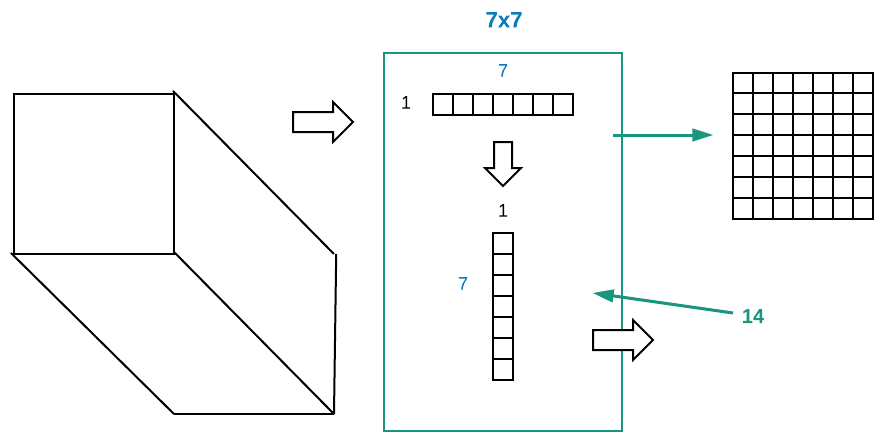

### Factored Convolutions
If you are interested in learning more about this, specifically in a deep learning area, you can google for Factored Convolutions. 
It work well and the Inception network uses it quite widely. 
They actually use it in their stem. 
We’ve talked before about how we tend to add-on — we tend to say this is main backbone when we have ResNet34, for example. 
This is main backbone which is all of the convolutions, and then we can add on to it a custom head that tends to be a max pooling or a fully connected layer. 
It’s better to talk about the backbone as containing two pieces: the stem and the main backbone. 
The input has only 3 channels, so we want some sequence of operations which is going to expand that out into something richer — generally something like 64 channels.

![image.png](attachment:image.png)

In ResNet, the stem is super simple. 
It’s a 7x7 stride 2 conv followed by a stride 2 max pool (verify). 
Inception have a much more complex stem with multiple paths getting combined and concatenated including factored conv (1x7 and 7x1). 
What would happen if, e.g., we stacked a standard ResNet on top of an Inception stem. 
An Inception stem is carefully engineered, and to take a 3 channel input and turn it into something richer is important. 
And that work seems to be thrown away for ResNet. 
ResNet works really well. 
But what if we put a densenet backbone on top of an Inception stem? 
Or what if we replaced the 7x7 conv with a 1x7 and 7x1 factored conv in standard ResNet? 
Lots of interesting things to try as potential research directions.

# image enhancement. 
Following paper connects the above Factored Convolusions with the next topic. 
It’s a paper on **progressive GANS** from Nvidia: [Progressive Growing of GANS for Improved Quality, Stability, and Variation.](http://research.nvidia.com/publication/2017-10_Progressive-Growing-of). 
Progressive GANS gradually increase the image size. 
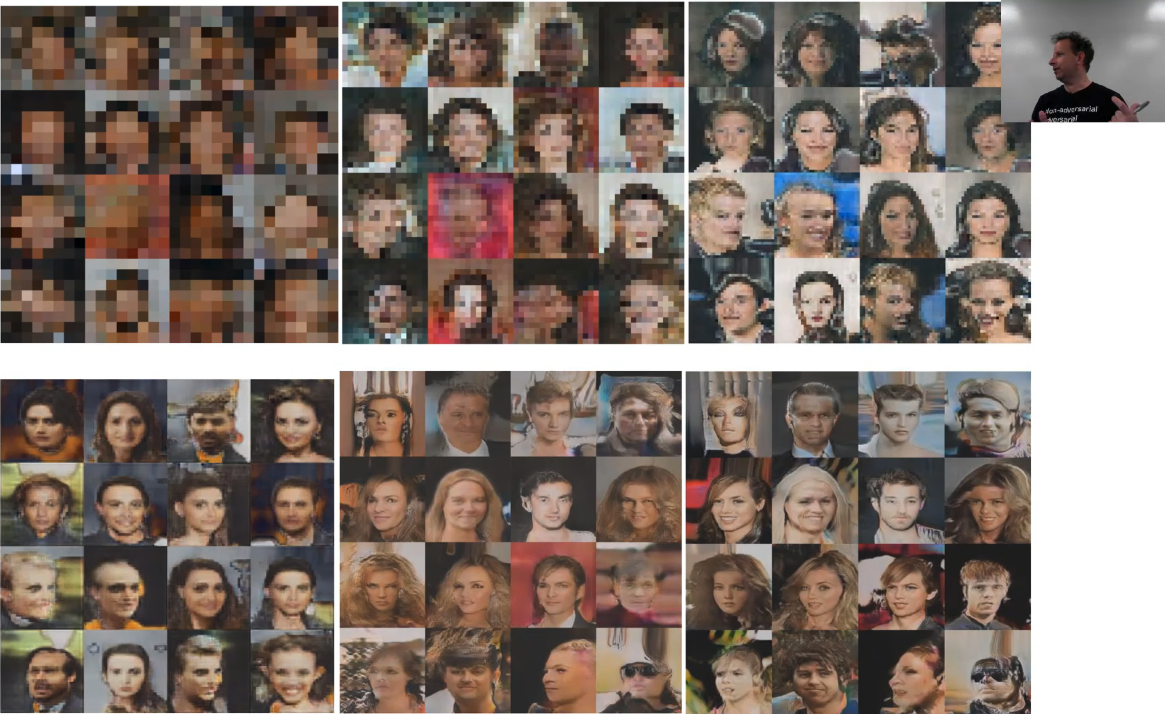

They really go back and they start with 4x4 GAN [31:47]. 
They are trying to replicate 4x4 pixel, and then 8x8 (the upper left ones above). 
This is the CelebA dataset, we are trying to recreate pictures of celebrities. 
Then they go 16x16, 32x32, 64x64, 128x128, then 256x256. 
As they increase the size, they also add more layers to the network. 
Makes sense because if you are doing more of a ResNet-y type thing, 
then you are spitting out something which hopefully makes sense at each grid cell size, 
so you should be able to layer stuff on top. 

They also add a skip connection when they do that, and they gradually change the linear interpolation parameter that moves it more and more away from the old 4x4 network and towards the new 8x8 network. 
Then once this totally moved it across, they throw away that extra connection. 
The details don’t matter too much but it uses the basic ideas we’ve talked about, gradually increasing the image size and skip connections. 
Great paper to study because good engineers built something that just works in a really sensible way. 
Nvidia don’t do a lot of papers, but when they do, they build something that is practical and sensible. 
Great paper to put together lots of the different things we’ve learned and there aren’t many re-implementation of this so it’s an interesting thing to project, 
and maybe you could build on and find something else.

next [33:45]. 
Eventually goes up to 1024x1024, and the images are not only getting higher resolution but they are getting better. 
Guess which one of the following is fake:

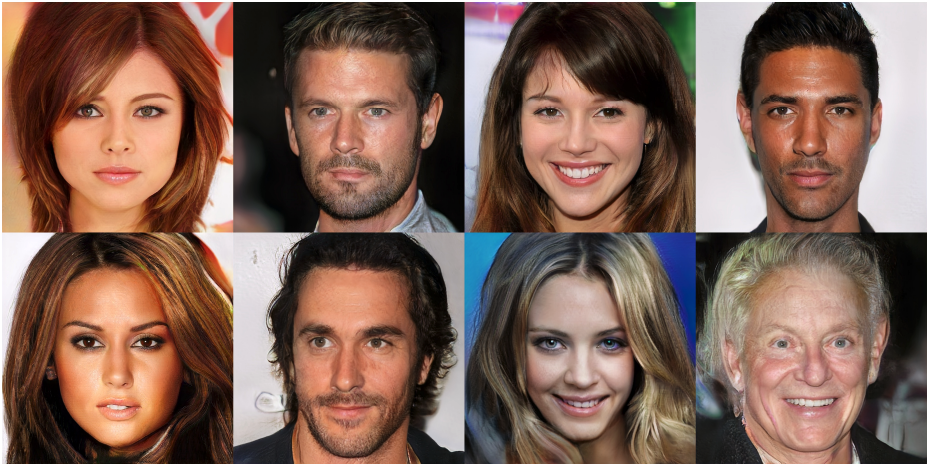
They are all fake. 
That’s the next stage. You go up up up up and them BOOM. 
So GANS are "getting crazy" ....  

This video is a (fake) [speech by Barack Obama](https://youtu.be/cQ54GDm1eL0).
As you can see, they’ve used this kind of technology to literally move Obama’s face in the way that Jordan Peele’s face was moving. You basically have all the techniques you need now to do that. Is that a good idea?